In [225]:
# Install required packages.
# %%capture

In [226]:
# !pip install -q git+https://github.com/snap-stanford/deepsnap.git

In [227]:
# !pip install -U -q PyDrive

In [228]:
# !pip install boto3

In [229]:
# !pip install seaborn

In [230]:
# !pip install bertopic

In [231]:
# !pip install torch==2.0.0

In [232]:
import torch
torch.__version__

'2.0.0+cu117'

In [233]:
# !pip uninstall torch-scatter torch-sparse torch-geometric torch-cluster  --y
# !pip install torch-scatter -f https://data.pyg.org/whl/torch-{torch.__version__}.html
# !pip install torch-sparse -f https://data.pyg.org/whl/torch-{torch.__version__}.html
# !pip install torch-cluster -f https://data.pyg.org/whl/torch-{torch.__version__}.html
# !pip install git+https://github.com/pyg-team/pytorch_geometric.git

In [234]:
# !pip install tqdm

In [235]:
import random
from tqdm import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import seaborn as sns
from torch import nn, optim, Tensor

from torch_sparse import SparseTensor, matmul

from torch_geometric.utils import structured_negative_sampling
from torch_geometric.data import download_url, extract_zip
from torch_geometric.nn.conv.gcn_conv import gcn_norm
from torch_geometric.nn.conv import MessagePassing
from torch_geometric.typing import Adj
import boto3
import json
import os
from io import StringIO 

In [236]:
BUCKET_NAME = 'ecc-scraper-data'
# # s3 = boto3.client('s3')

s3 = boto3.client('s3', 
                          aws_access_key_id='XXX',
                          aws_secret_access_key='XXX',
                          region_name='us-east-2'
                      )

In [237]:
objects = s3.list_objects_v2(Bucket=BUCKET_NAME)['Contents']
objects = list( objects)

final_data = []
post_reactions = {}

for obj in objects:
    if(obj['Key']=='preprocessed_data.csv'):
        contents = s3.get_object(Bucket=BUCKET_NAME, Key=obj['Key'])
        contents = contents['Body'].read().decode('utf-8')
        df = pd.read_csv(StringIO(contents), index_col=0)
        
        break

In [238]:
df.rename( columns={0 :'id'}, inplace=True )

In [239]:
df.columns

Index(['post_id', 'timestamp', 'source', 'current_user', 'authorUrl',
       'authorImage', 'author', 'text', 'n_reposts', 'n_reactions',
       'n_comments', 'reaction', 'post_without_stopwords', 'post_lemmatized',
       'topic_id', 'top_words', 'topic_name'],
      dtype='object')

In [240]:
def load_node_csv(old_df, index_col):
    """Loads csv containing node information

    Args:
        path (str): path to csv file
        index_col (str): column name of index column

    Returns:
        dict: mapping of csv row to node id
    """
    df = old_df.set_index(index_col)
    mapping = {index: i for i, index in enumerate(df.index.unique())}
    return mapping

In [241]:
user_mapping = load_node_csv(df, index_col='current_user')
post_mapping = load_node_csv(df, index_col='post_id')
author_mapping = load_node_csv(df, index_col='authorUrl')

In [242]:
len(user_mapping.keys())

7

In [243]:
user_mapping

{'karthikshathiri': 0,
 'kssreesha': 1,
 'newsstorygoogle-search-to-add-ai-chat-feature-5598532': 2,
 'mitali-tavildar-profile': 3,
 'newsstoryjob-openings-sink-below-10m-5594252': 4,
 'mitali-tavildar': 5,
 'skini25': 6}

In [244]:
len(post_mapping.keys())

1254

In [245]:
len(author_mapping.keys())

872

In [246]:
# load edges between users and posts
def load_edge_csv(df, src_index_col, src_mapping, dst_index_col, dst_mapping, edge_value):
    """Loads csv containing edges between users and items

    Args:
        path (str): path to csv file
        src_index_col (str): column name of users
        src_mapping (dict): mapping between row number and user id
        dst_index_col (str): column name of items
        dst_mapping (dict): mapping between row number and item id

    Returns:
        torch.Tensor: 2 by N matrix containing the node ids of N user-item edges
    """

    edge_index = None
    src = [src_mapping[index] for index in df[src_index_col]]
    dst = [dst_mapping[index] for index in df[dst_index_col]]
    edge_attr = torch.from_numpy( edge_value(df).to_numpy() ).view(-1, 1).to(torch.long)


    edge_index = [[], []]
    for i in range(edge_attr.shape[0]):
        if edge_attr[i]:
            edge_index[0].append(src[i])
            edge_index[1].append(dst[i])

    return torch.tensor(edge_index)

def edge_user_post_value(data):
  repost_cube =  np.power(data['n_reposts'], 3) 
  react_sqrt = np.power(data['n_reactions'], 2)
  comment = data['n_comments']
  react = data['reaction']
  
  # adds one if the user has reacted to the post
  # adds more priority if the post is in the users timeline and has more reposts, reactions and comments

  return react * ( repost_cube + react_sqrt + comment )
                             
edge_user_post = load_edge_csv(
    df,
    src_index_col='current_user',
    src_mapping=user_mapping,
    dst_index_col='post_id',
    dst_mapping=post_mapping,
    edge_value=edge_user_post_value
)

print( edge_user_post.shape )

torch.Size([2, 107])


In [247]:
# used in case the author descides to use our product
# currently this is not used in the model

def edge_author_post_value(data):
  repost_quad =  np.power(data['n_reposts'], 4) 
  react_sqrt = np.power(data['n_reactions'], 2)
  comment = data['n_comments']
  return repost_quad + react_sqrt + comment

edge_author_post = load_edge_csv(
    df,
    src_index_col='authorUrl',
    src_mapping=author_mapping,
    dst_index_col='post_id',
    dst_mapping=post_mapping,
    edge_value=edge_author_post_value
)
print( edge_author_post.shape )

torch.Size([2, 1227])


In [248]:
# split the edges of the graph using a 80/10/10 train/validation/test split
num_users, num_posts = len(user_mapping), len(post_mapping)
num_interactions = edge_user_post.shape[1]
all_indices = [i for i in range(num_interactions)]

train_indices, test_indices = train_test_split(
    all_indices, test_size=0.2, random_state=1)
val_indices, test_indices = train_test_split(
    test_indices, test_size=0.5, random_state=1)


train_edge_index = edge_user_post[:, train_indices]
val_edge_index = edge_user_post[:, val_indices]
test_edge_index = edge_user_post[:, test_indices]

In [249]:
# convert edge indices into Sparse Tensors: https://pytorch-geometric.readthedocs.io/en/latest/notes/sparse_tensor.html
train_sparse_edge_index = SparseTensor(row=train_edge_index[0], col=train_edge_index[1], sparse_sizes=(
    num_users + num_posts, num_users + num_posts))


In [250]:
val_sparse_edge_index = SparseTensor(row=val_edge_index[0], col=val_edge_index[1], sparse_sizes=(
    num_users + num_posts, num_users + num_posts))


In [251]:
test_sparse_edge_index = SparseTensor(row=test_edge_index[0], col=test_edge_index[1], sparse_sizes=(
    num_users + num_posts, num_users + num_posts))

In [252]:
# code from pytorch geometric lightgcn_pyg.ipynb implementation
# defines LightGCN model
class LightGCN(MessagePassing):
    """LightGCN Model as proposed in https://arxiv.org/abs/2002.02126
    """

    def __init__(self, num_users, num_items, edge_user_post, embedding_dim=64, K=3, add_self_loops=False):
        """Initializes LightGCN Model

        Args:
            num_users (int): Number of users
            num_items (int): Number of items
            embedding_dim (int, optional): Dimensionality of embeddings. Defaults to 8.
            K (int, optional): Number of message passing layers. Defaults to 3.
            add_self_loops (bool, optional): Whether to add self loops for message passing. Defaults to False.
        """
        super().__init__()
        self.num_users, self.num_items = num_users, num_items
        self.embedding_dim, self.K = embedding_dim, K
        self.add_self_loops = add_self_loops

        self.users_emb = nn.Embedding(
            num_embeddings=self.num_users, embedding_dim=self.embedding_dim) # e_u^0
        self.items_emb = nn.Embedding(
            num_embeddings=self.num_items, embedding_dim=self.embedding_dim) # e_i^0
        self.edge_user_post = edge_user_post
        
        nn.init.normal_(self.users_emb.weight, std=0.1)
        nn.init.normal_(self.items_emb.weight, std=0.1)

    def forward(self, edge_index: SparseTensor):
        """Forward propagation of LightGCN Model.

        Args:
            edge_index (SparseTensor): adjacency matrix

        Returns:
            tuple (Tensor): e_u_k, e_u_0, e_i_k, e_i_0
        """
        # compute \tilde{A}: symmetrically normalized adjacency matrix
        edge_index_norm = gcn_norm(
            edge_index, add_self_loops=self.add_self_loops)

        emb_0 = torch.cat([self.users_emb.weight, self.items_emb.weight]) # E^0
        embs = [emb_0]
        emb_k = emb_0

        # multi-scale diffusion
        for i in range(self.K):
            emb_k = self.propagate(edge_index_norm, x=emb_k)
            embs.append(emb_k)

        embs = torch.stack(embs, dim=1)
        emb_final = torch.mean(embs, dim=1) # E^K

        users_emb_final, items_emb_final = torch.split(
            emb_final, [self.num_users, self.num_items]) # splits into e_u^K and e_i^K

        # returns e_u^K, e_u^0, e_i^K, e_i^0
        return users_emb_final, self.users_emb.weight, items_emb_final, self.items_emb.weight

    def message(self, x_j: Tensor) -> Tensor:
        return x_j

    def message_and_aggregate(self, adj_t: SparseTensor, x: Tensor) -> Tensor:
        # computes \tilde{A} @ x
        return matmul(adj_t, x)

model = LightGCN(num_users, num_posts, edge_user_post)

In [253]:
def bpr_loss(users_emb_final, users_emb_0, pos_items_emb_final, pos_items_emb_0, neg_items_emb_final, neg_items_emb_0, lambda_val):
    """Bayesian Personalized Ranking Loss as described in https://arxiv.org/abs/1205.2618

    Args:
        users_emb_final (torch.Tensor): e_u_k
        users_emb_0 (torch.Tensor): e_u_0
        pos_items_emb_final (torch.Tensor): positive e_i_k
        pos_items_emb_0 (torch.Tensor): positive e_i_0
        neg_items_emb_final (torch.Tensor): negative e_i_k
        neg_items_emb_0 (torch.Tensor): negative e_i_0
        lambda_val (float): lambda value for regularization loss term

    Returns:
        torch.Tensor: scalar bpr loss value
    """
    reg_loss = lambda_val * (users_emb_0.norm(2).pow(2) +
                             pos_items_emb_0.norm(2).pow(2) +
                             neg_items_emb_0.norm(2).pow(2)) # L2 loss

    pos_scores = torch.mul(users_emb_final, pos_items_emb_final)
    pos_scores = torch.sum(pos_scores, dim=-1) # predicted scores of positive samples
    neg_scores = torch.mul(users_emb_final, neg_items_emb_final)
    neg_scores = torch.sum(neg_scores, dim=-1) # predicted scores of negative samples

    loss = -torch.mean(torch.nn.functional.softplus(pos_scores - neg_scores)) + reg_loss

    return loss

In [254]:
# helper function to get N_u
def get_user_positive_items(edge_index):
    """Generates dictionary of positive items for each user

    Args:
        edge_index (torch.Tensor): 2 by N list of edges

    Returns:
        dict: dictionary of positive items for each user
    """
    user_pos_items = {}
    for i in range(edge_index.shape[1]):
        user = edge_index[0][i].item()
        item = edge_index[1][i].item()
        if user not in user_pos_items:
            user_pos_items[user] = []
        user_pos_items[user].append(item)
    return user_pos_items

In [255]:
# computes recall@K and precision@K
def RecallPrecision_ATk(groundTruth, r, k):
    """Computers recall @ k and precision @ k

    Args:
        groundTruth (list): list of lists containing highly rated items of each user
        r (list): list of lists indicating whether each top k item recommended to each user
            is a top k ground truth item or not
        k (intg): determines the top k items to compute precision and recall on

    Returns:
        tuple: recall @ k, precision @ k
    """
    num_correct_pred = torch.sum(r, dim=-1)  # number of correctly predicted items per user
    # number of items liked by each user in the test set
    user_num_liked = torch.Tensor([len(groundTruth[i])
                                  for i in range(len(groundTruth))])
    recall = torch.mean(num_correct_pred / user_num_liked)
    precision = torch.mean(num_correct_pred) / k
    return recall.item(), precision.item()

In [256]:
# computes NDCG@K
def NDCGatK_r(groundTruth, r, k):
    """Computes Normalized Discounted Cumulative Gain (NDCG) @ k

    Args:
        groundTruth (list): list of lists containing highly rated items of each user
        r (list): list of lists indicating whether each top k item recommended to each user
            is a top k ground truth item or not
        k (int): determines the top k items to compute ndcg on

    Returns:
        float: ndcg @ k
    """
    assert len(r) == len(groundTruth)

    test_matrix = torch.zeros((len(r), k))

    for i, items in enumerate(groundTruth):
        length = min(len(items), k)
        test_matrix[i, :length] = 1
    max_r = test_matrix
    idcg = torch.sum(max_r * 1. / torch.log2(torch.arange(2, k + 2)), axis=1)
    dcg = r * (1. / torch.log2(torch.arange(2, k + 2)))
    dcg = torch.sum(dcg, axis=1)
    idcg[idcg == 0.] = 1.
    ndcg = dcg / idcg
    ndcg[torch.isnan(ndcg)] = 0.
    return torch.mean(ndcg).item()

In [257]:
# wrapper function to get evaluation metrics
def get_metrics(model, edge_index, exclude_edge_indices, k):
    """Computes the evaluation metrics: recall, precision, and ndcg @ k

    Args:
        model (LighGCN): lightgcn model
        edge_index (torch.Tensor): 2 by N list of edges for split to evaluate
        exclude_edge_indices ([type]): 2 by N list of edges for split to discount from evaluation
        k (int): determines the top k items to compute metrics on

    Returns:
        tuple: recall @ k, precision @ k, ndcg @ k
    """
    user_embedding = model.users_emb.weight
    item_embedding = model.items_emb.weight

    # get edge weights between every user and item - shape is num users x num posts
    edge_weight = torch.matmul(user_embedding, item_embedding.T)

    for exclude_edge_index in exclude_edge_indices:
        # gets all the positive items for each user from the edge index
        user_pos_items = get_user_positive_items(exclude_edge_index)
        # get coordinates of all edges to exclude
        exclude_users = []
        exclude_items = []
        for user, items in user_pos_items.items():
            exclude_users.extend([user] * len(items))
            exclude_items.extend(items)

        # set weights of excluded edges to large negative value
        edge_weight[exclude_users, exclude_items] = -(1 << 10)

    # get the top k recommended items for each user
    _, top_K_items = torch.topk(edge_weight, k=k)

    # get all unique users in evaluated split
    users = edge_index[0].unique()

    test_user_pos_items = get_user_positive_items(edge_index)

    # convert test user pos items dictionary into a list
    test_user_pos_items_list = [
        test_user_pos_items[user.item()] for user in users]

    # determine the correctness of topk predictions
    r = []
    for user in users:
        ground_truth_items = test_user_pos_items[user.item()]
        label = list(map(lambda x: x in ground_truth_items, top_K_items[user]))
        r.append(label)
    r = torch.Tensor(np.array(r).astype('float'))

    recall, precision = RecallPrecision_ATk(test_user_pos_items_list, r, k)
    ndcg = NDCGatK_r(test_user_pos_items_list, r, k)

    return recall, precision, ndcg

In [258]:
# wrapper function to evaluate model
def evaluation(model, edge_index, sparse_edge_index, exclude_edge_indices, k, lambda_val):
    """Evaluates model loss and metrics including recall, precision, ndcg @ k

    Args:
        model (LighGCN): lightgcn model
        edge_index (torch.Tensor): 2 by N list of edges for split to evaluate
        sparse_edge_index (sparseTensor): sparse adjacency matrix for split to evaluate
        exclude_edge_indices ([type]): 2 by N list of edges for split to discount from evaluation
        k (int): determines the top k items to compute metrics on
        lambda_val (float): determines lambda for bpr loss

    Returns:
        tuple: bpr loss, recall @ k, precision @ k, ndcg @ k
    """
    # get embeddings
    users_emb_final, users_emb_0, items_emb_final, items_emb_0 = model.forward(
        sparse_edge_index)
    edges = structured_negative_sampling(
        edge_index, contains_neg_self_loops=False)
    user_indices, pos_item_indices, neg_item_indices = edges[0], edges[1], edges[2]
    users_emb_final, users_emb_0 = users_emb_final[user_indices], users_emb_0[user_indices]
    pos_items_emb_final, pos_items_emb_0 = items_emb_final[
        pos_item_indices], items_emb_0[pos_item_indices]
    neg_items_emb_final, neg_items_emb_0 = items_emb_final[
        neg_item_indices], items_emb_0[neg_item_indices]

    loss = bpr_loss(users_emb_final, users_emb_0, pos_items_emb_final, pos_items_emb_0,
                    neg_items_emb_final, neg_items_emb_0, lambda_val).item()

    recall, precision, ndcg = get_metrics(
        model, edge_index, exclude_edge_indices, k)

    return loss, recall, precision, ndcg

In [259]:
# function which random samples a mini-batch of positive and negative samples
def sample_mini_batch(batch_size, edge_index):
    """Randomly samples indices of a minibatch given an adjacency matrix

    Args:
        batch_size (int): minibatch size
        edge_index (torch.Tensor): 2 by N list of edges

    Returns:
        tuple: user indices, positive item indices, negative item indices
    """
    edges = structured_negative_sampling(edge_index)
    edges = torch.stack(edges, dim=0)
    indices = random.choices(
        [i for i in range(edges[0].shape[0])], k=batch_size)
    batch = edges[:, indices]
    user_indices, pos_item_indices, neg_item_indices = batch[0], batch[1], batch[2]
    return user_indices, pos_item_indices, neg_item_indices

In [260]:
# define constants
ITERATIONS = 10000
BATCH_SIZE = 1024
LR = 1e-3
ITERS_PER_EVAL = 200
ITERS_PER_LR_DECAY = 200
K = 20
LAMBDA = 1e-6

In [261]:
# setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device {device}.")


model = model.to(device)
model.train()

optimizer = optim.Adam(model.parameters(), lr=LR)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)

edge_user_post = edge_user_post.to(device)
train_edge_index = train_edge_index.to(device)
train_sparse_edge_index = train_sparse_edge_index.to(device)

val_edge_index = val_edge_index.to(device)
val_sparse_edge_index = val_sparse_edge_index.to(device)

Using device cuda.


In [262]:
# training loop
train_losses = []
val_losses = []

precisions = []
recalls = []

for iter in range(ITERATIONS):
    # forward propagation
    users_emb_final, users_emb_0, items_emb_final, items_emb_0 = model.forward(
        train_sparse_edge_index)

    # mini batching
    user_indices, pos_item_indices, neg_item_indices = sample_mini_batch(
        BATCH_SIZE, train_edge_index)
    user_indices, pos_item_indices, neg_item_indices = user_indices.to(
        device), pos_item_indices.to(device), neg_item_indices.to(device)
    users_emb_final, users_emb_0 = users_emb_final[user_indices], users_emb_0[user_indices]
    pos_items_emb_final, pos_items_emb_0 = items_emb_final[
        pos_item_indices], items_emb_0[pos_item_indices]
    neg_items_emb_final, neg_items_emb_0 = items_emb_final[
        neg_item_indices], items_emb_0[neg_item_indices]

    # loss computation
    train_loss = bpr_loss(users_emb_final, users_emb_0, pos_items_emb_final,
                          pos_items_emb_0, neg_items_emb_final, neg_items_emb_0, LAMBDA)

    optimizer.zero_grad()
    train_loss.backward()
    optimizer.step()

    if iter % ITERS_PER_EVAL == 0:
        model.eval()
        val_loss, recall, precision, ndcg = evaluation(
            model, val_edge_index, val_sparse_edge_index, [train_edge_index], K, LAMBDA)
        print(f"[Iteration {iter}/{ITERATIONS}] train_loss: {round(train_loss.item(), 5)}, val_loss: {round(val_loss, 5)}, val_recall@{K}: {round(recall, 5)}, val_precision@{K}: {round(precision, 5)}, val_ndcg@{K}: {round(ndcg, 5)}")
        
        precisions.append(precision)
        recalls.append(recall)
        
        train_losses.append(train_loss.item())
        val_losses.append(val_loss)
        model.train()

    if iter % ITERS_PER_LR_DECAY == 0 and iter != 0:
        scheduler.step()

[Iteration 0/10000] train_loss: -0.69137, val_loss: -0.69229, val_recall@20: 0.0, val_precision@20: 0.0, val_ndcg@20: 0.0
[Iteration 200/10000] train_loss: -0.9224, val_loss: -0.64805, val_recall@20: 0.0, val_precision@20: 0.0, val_ndcg@20: 0.0
[Iteration 400/10000] train_loss: -2.07656, val_loss: -0.6614, val_recall@20: 0.0, val_precision@20: 0.0, val_ndcg@20: 0.0
[Iteration 600/10000] train_loss: -4.3711, val_loss: -0.50259, val_recall@20: 0.0, val_precision@20: 0.0, val_ndcg@20: 0.0
[Iteration 800/10000] train_loss: -7.30087, val_loss: -0.53427, val_recall@20: 0.0, val_precision@20: 0.0, val_ndcg@20: 0.0
[Iteration 1000/10000] train_loss: -10.50261, val_loss: -0.56393, val_recall@20: 0.0, val_precision@20: 0.0, val_ndcg@20: 0.0
[Iteration 1200/10000] train_loss: -13.84834, val_loss: -0.57736, val_recall@20: 0.0, val_precision@20: 0.0, val_ndcg@20: 0.0
[Iteration 1400/10000] train_loss: -17.37877, val_loss: -0.53812, val_recall@20: 0.0, val_precision@20: 0.0, val_ndcg@20: 0.0
[Iterat

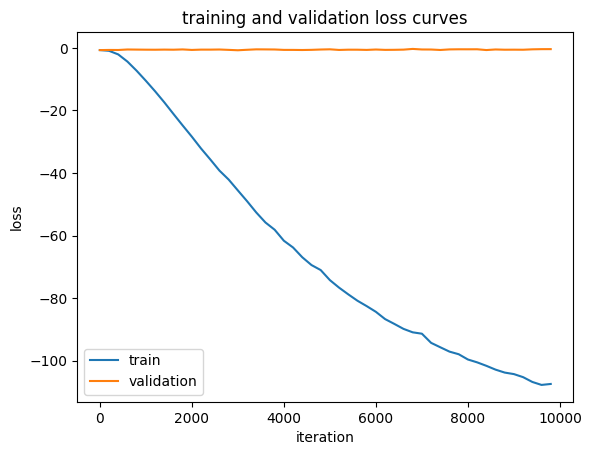

In [263]:
iters = [iter * ITERS_PER_EVAL for iter in range(len(train_losses))]
plt.plot(iters, train_losses, label='train')
plt.plot(iters, val_losses, label='validation')
plt.xlabel('iteration')
plt.ylabel('loss')
plt.title('training and validation loss curves')
plt.legend()
plt.show()

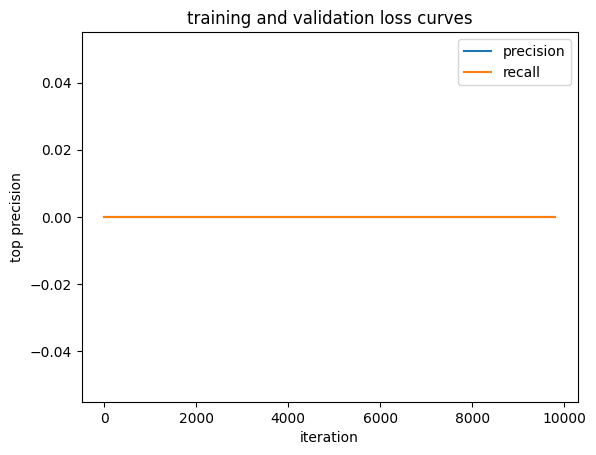

In [280]:
iters = [iter * ITERS_PER_EVAL for iter in range(len(train_losses))]
plt.plot(iters, precisions, label='precision')
plt.plot(iters, recalls, label='recall')
plt.xlabel('iteration')
plt.ylabel('top precision')
plt.title('training and validation loss curves')
plt.legend()
plt.show()

In [264]:
model.users_emb.weight.shape

torch.Size([7, 64])

In [265]:
torch.save(model, 'saved_model.pt')

In [266]:
s3.upload_file(
    Filename=os.path.join('.', 'saved_model.pt'),
    Bucket='ecc-model-dump',
    Key='saved_model.pt',
)

In [267]:
s3.download_file(
    'ecc-model-dump',
    'saved_model.pt', 
    'saved_model.pt'
)

In [268]:
model2 = torch.load('saved_model.pt')

In [269]:
# model2 = LightGCN(num_users, num_posts)
# with open(os.path.join('.', 'saved_model.pt'), 'rb') as f:
#     model2.load_state_dict(torch.load(f))

In [270]:
model2.users_emb.weight.shape

torch.Size([7, 64])

In [271]:
model = model2

In [272]:
# evaluate on test set
model.eval()
test_edge_index = test_edge_index.to(device)
test_sparse_edge_index = test_sparse_edge_index.to(device)

test_loss, test_recall, test_precision, test_ndcg = evaluation(
            model, test_edge_index, test_sparse_edge_index, [train_edge_index, val_edge_index], K, LAMBDA)

print(f"[test_loss: {round(test_loss, 5)}, test_recall@{K}: {round(test_recall, 5)}, test_precision@{K}: {round(test_precision, 5)}, test_ndcg@{K}: {round(test_ndcg, 5)}")

[test_loss: -0.71362, test_recall@20: 0.0, test_precision@20: 0.0, test_ndcg@20: 0.0


In [273]:
model.eval()

postid_text = pd.Series(df.text.values, index=df.post_id).to_dict()
postid_author = pd.Series(df.author.values, index=df.post_id).to_dict()
postid_original_user = pd.Series(df.current_user.values, index=df.post_id).to_dict()

user_pos_items = get_user_positive_items(edge_user_post)

In [274]:
def make_predictions(user_id, num_recs):
    if user_id not in user_mapping:
        print('User does not exist')
        return
    
    user = user_mapping[user_id]
    e_u = model.users_emb.weight[user]
    scores = model.items_emb.weight @ e_u
    
    values, indices = torch.topk(scores, k=len(user_pos_items[user]) + num_recs)
    
    posts = [index.cpu().item() for index in indices if index in user_pos_items[user]][:num_recs]
    
    post_ids = [list(post_mapping.keys())[list(post_mapping.values()).index(post)] for post in posts]
    texts = [postid_text[id] for id in post_ids]
    authors =  [postid_author[id] for id in post_ids]
    original_users = [postid_original_user[id] for id in post_ids]
    
    data = {}
    data['user'] = user_id
    data['liked'] = []
    data['recommended'] = []
    
    print(f"Here are some posts that user {user_id} liked")
    for i in range(len(post_ids)):
        data['liked'].append(
            {
                'author': str(authors[i]),
                'original_user': original_users[i],
                'post_id': f"https://www.linkedin.com/feed/update/{post_ids[i]}/",
                'post_body': texts[i]
            }
        )
        print("--------------------------------------------------------")
        print(f"Author: {authors[i]}")
        print(f"Original user: {original_users[i]} ")
        print(f"Post URL: https://www.linkedin.com/feed/update/{post_ids[i]}/")
        print(f"Post Body: {texts[i]} ")

    print()

    posts = [index.cpu().item() for index in indices if index not in user_pos_items[user]][:num_recs]
    post_ids = [list(post_mapping.keys())[list(post_mapping.values()).index(post)] for post in posts]
    texts = [postid_text[id] for id in post_ids]
    authors =  [postid_author[id] for id in post_ids]
    original_users = [postid_original_user[id] for id in post_ids]

    print(f"Here are some suggested posts for user {user_id}")
    for i in range(len(post_ids)):
        data['recommended'].append(
            {
                'author': authors[i],
                'original_user': original_users[i],
                'post_id': f"https://www.linkedin.com/feed/update/{post_ids[i]}/",
                'post_body': texts[i]
            }
        )
        print("--------------------------------------------------------")
        print(f"Author: {authors[i]} ")
        print(f"Original user: {original_users[i]} ")
        print(f"Post URL: https://www.linkedin.com/feed/update/{post_ids[i]}/")
        print(f"Post Body: {texts[i]} ")
    
    
    return data

In [275]:
data = make_predictions('skini25', 1)

Here are some posts that user skini25 liked
--------------------------------------------------------
Author: Matt Gray
Original user: skini25 
Post URL: https://www.linkedin.com/feed/update/urn:li:activity:7049046438068056064/
Post Body: Twitter just open-sourced their algorithm. I spent my Saturday night checking it out. There are a ton of hidden gems for growth. Here are 6 insights to increase your reach: 

Here are some suggested posts for user skini25
--------------------------------------------------------
Author: Nikhit Nair 
Original user: kssreesha 
Post URL: https://www.linkedin.com/feed/update/urn:li:activity:7052156840830259200/
Post Body: I'm happy to share, I am starting a new role as Associate Architect at Myntra. #newrole 


In [276]:
# %%capture

# !sudo apt-get install texlive-xetex texlive-fonts-recommended texlive-plain-generic

# !jupyter nbconvert --to PDF "gnn_pytorch.ipynb"

In [277]:
# !pip list --format=freeze > requirements2.txt

In [278]:
config_dict = {
    "num_samples_per_user": 500,
    "num_users": 200,

    "epochs": 100,
    "batch_size": 128,
    "lr": 0.001,
    "weight_decay": 0.1,

    "embedding_size": 64,
    "num_layers": 5,
    "K": 10,
    "mf_rank": 8,

    "minibatch_per_print": 100,
    "epochs_per_print": 1,

    "val_frac": 0.2,
    "test_frac": 0.1,

    "model_name": "model.pth"
}

In [279]:
# n_users = num_users
# m_items = num_posts
# print(f"#Users: {n_users}")
# print(f"#Items: {m_items}")

# model_config = {
#     "n_users": n_users,
#     "m_items": m_items,
#     "embedding_size": config_dict["embedding_size"],
#     "num_layers": config_dict["num_layers"],
# }

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# lightGCN = LightGCN(n_users, m_items, config_dict["embedding_size"],config_dict["num_layers"])

# scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)

# edge_user_post = edge_user_post.to(device)
# train_edge_index = train_edge_index.to(device)
# train_sparse_edge_index = train_sparse_edge_index.to(device)

# val_edge_index = val_edge_index.to(device)
# val_sparse_edge_index = val_sparse_edge_index.to(device)

# print(f"#Training samples: {len(samples_train)}",
#       f"#Validation samples: {len(samples_val)}",
#       f"#Test samples: {len(samples_test)}")

# optimizer = optim.Adam(lightGCN.parameters(), lr=lr)
# print("Optimizer:", optimizer)

# epochs_tracked = []
# train_topks = []
# val_topks = []

# # training loop
# train_losses = []
# val_losses = []

# ITERATIONS = config_dict["epochs"]
# BATCH_SIZE = config_dict["batch_size"]
# LR = = config_dict["lr"]
# weight_decay = config_dict["weight_decay"]

# # number of message passing layers
# K = config_dict["K"]

# lightGCN.to(device)

# for iter in range(ITERATIONS):
#     # forward propagation
#     users_emb_final, users_emb_0, items_emb_final, items_emb_0 = model.forward(
#         train_sparse_edge_index)

#     # mini batching
#     user_indices, pos_item_indices, neg_item_indices = sample_mini_batch(
#         BATCH_SIZE, train_edge_index)
#     user_indices, pos_item_indices, neg_item_indices = user_indices.to(
#         device), pos_item_indices.to(device), neg_item_indices.to(device)
#     users_emb_final, users_emb_0 = users_emb_final[user_indices], users_emb_0[user_indices]
#     pos_items_emb_final, pos_items_emb_0 = items_emb_final[
#         pos_item_indices], items_emb_0[pos_item_indices]
#     neg_items_emb_final, neg_items_emb_0 = items_emb_final[
#         neg_item_indices], items_emb_0[neg_item_indices]

#     # loss computation
#     train_loss = bpr_loss(users_emb_final, users_emb_0, pos_items_emb_final,
#                           pos_items_emb_0, neg_items_emb_final, neg_items_emb_0, LAMBDA)

#     optimizer.zero_grad()
#     train_loss.backward()
#     optimizer.step()

#     if iter % ITERS_PER_EVAL == 0:
#         model.eval()
#         val_loss, recall, precision, ndcg = evaluation(
#             model, val_edge_index, val_sparse_edge_index, [train_edge_index], K, LAMBDA)
#         print(f"[Iteration {iter}/{ITERATIONS}] train_loss: {round(train_loss.item(), 5)}, val_loss: {round(val_loss, 5)}, val_recall@{K}: {round(recall, 5)}, val_precision@{K}: {round(precision, 5)}, val_ndcg@{K}: {round(ndcg, 5)}")
#         train_losses.append(train_loss.item())
#         val_losses.append(val_loss)
#         model.train()

#     if iter % ITERS_PER_LR_DECAY == 0 and iter != 0:
#         scheduler.step()